# IMPORT LIB

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets, svm, metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# HELPFUL FUNCTIONS

In [21]:
def apply_marital_age(y, x):
  if y == 'unknown':
    if x < 33:
      return 'single'
    else:
      return 'married'
  else:
    return y

def apply_rank(x):
  if x == 0:
    return 'illiterate'
  elif x == 1:
    return 'basic.6y'
  elif x == 2:
    return 'high.school'
  else:
    return 'university.degree'

def fill_education(df):
  #fill nan bang 2
  df['education'].fillna(2, inplace = True)
  for i in range(len(df['education'])):
    if df['education'].iloc[i] == 2:
      df['education'].iloc[i] = apply_rank(df['job_rank'].iloc[i])
    else:
      pass
  return df
  

def apply_age_group(age):
  if age < 35:
    return 'young'
  elif (age >= 35) & (age < 50):
    return 'middle_age'
  else:
    return 'old'

def apply_duration(x):
  if x < 120:
    return 'less_2mins'
  elif (x >= 120) & (x < 240):
    return '2mins_4mins'
  else:
    return 'more_4mins'

def apply_campaign(x):
  if x >= 3:
    return 'more_than_two'
  elif x == 1:
    return 'one'
  elif x == 2:
    return 'two'

def apply_pdays(x):
  if x == 999:
    return 'more'
  else:
    return 'less'

def apply_previous(x):
  if x >= 3:
    return 'more_than_2'
  elif x == 0:
    return 'zero'
  elif x == 1:
    return 'one'
  elif x == 2:
    return 'two'

def apply_y(x):
  if x == 'yes':
    return 1
  else:
    return 0

def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns = cols)
    return df

# DATA PREPROCESSING

In [22]:
def remove_duplicated(df):
  df = df.drop_duplicates(keep='first')
  df = df.loc[:,~dat.columns.duplicated()]
  return df

def fillna_by_mode(df):
  #marital
  for i in range(len(df['marital'])):
    value = apply_marital_age(df['marital'].iloc[i], df['age'].iloc[i])
    df['marital'].iloc[i] = value

  df = df.replace(to_replace ="unknown",value = np.nan)
  #job
  df['job'].fillna(df['job'].mode()[0], inplace=True)
  # housing , loan
  df['housing'].fillna(df['housing'].mode()[0], inplace=True)
  df['loan'].fillna(df['loan'].mode()[0], inplace=True)
  
  # default
  df['default'].fillna(df['default'].mode()[0], inplace=True)

  #education
  job_rank = {
    'unemployed': 0, 'student' : 1, 'retired' : 1, 'housemaid': 1,
    'blue-collar' : 2, 'admin.' : 2, 'services' : 2, 'technician' : 2,
    'management': 3, 'self-employed' : 3, 'entrepreneur' : 3}
  df['job_rank'] = df['job'].replace(job_rank)
  df = fill_education(df)
  return df


def generate_cols(df):
  #job - job_rank
  # job_rank = {
  #   'unemployed': 0, 'student' : 1, 'retired' : 1, 'housemaid': 1,
  #   'blue-collar' : 2, 'admin.' : 2, 'services' : 2, 'technician' : 2,
  #   'management': 3, 'self-employed' : 3, 'entrepreneur' : 3}
  # df['job_rank'] = df['job'].replace(job_rank)

  #month - day
  df['month_num'] = df['month'].replace({'may': 5, 'jul': 7, 'aug': 8, 'jun': 6, 'nov': 11,
                                          'apr': 4, 'oct': 10, 'sep': 9, 'mar': 3, 'dec': 12})
  df['day_num'] = df['day_of_week'].replace({'thu': 5, 'mon': 2, 'wed': 4, 'tue': 3, 'fri':6})

  #duration
  df['duration_group'] = df['duration'].apply(lambda x : apply_duration(x))
  df['campaign_group'] = df['campaign'].apply(lambda x : apply_campaign(x))
  df['pdays_group'] = df['campaign'].apply(lambda x : apply_pdays(x))
  df['previous_group'] = df['previous'].apply(lambda x : apply_previous(x))
  df['y'] = df['y'].apply(lambda x : apply_y(x))
  df['age_group'] = df['age'].apply(lambda x: apply_age_group(x))
  return df

def remove_feature_high_corr(df):
  cols = []
  for a in range(len(df.corr().columns)):
    for b in range(a):
        if abs(df.corr().iloc[a,b]) >0.7:
            name = df.corr().columns[a]
            cols.append(name)
  if len(cols) == 0:
    return df
  else:
    df = df.drop(columns= cols)
    return df
  

def encode(df):
  scaler = sklearn.preprocessing.StandardScaler()
  maxmin = sklearn.preprocessing.MinMaxScaler()
  #standarscaler:
  standar_scaler_cols = ['duration','campaign','previous','emp.var.rate','cons.conf.idx','job_rank']
  df[standar_scaler_cols] = scaler.fit_transform(df[standar_scaler_cols])
  #min max scaler
  df[['age', 'month_num', 'day_num']] = maxmin.fit_transform(df[['age', 'month_num', 'day_num']])
  #one hot
  onehot_cols = ['marital','default','housing','loan','contact','poutcome',
 'age_group','duration_group','campaign_group','pdays_group','previous_group']
  df = one_hot(df, onehot_cols)
  df = df.drop(columns = ['month', 'day_of_week'])
  return df

def select_features(df):
  df_cop = df[['age', 'duration', 'campaign', 'pdays', 'emp.var.rate', 'job_rank', 'month_num', 'cons.conf.idx', 'y']]
  return df_cop

In [66]:
def trainTestSplit(df):
    y1 = df['y']
    X1 = df.drop(columns = ['y'])

    X_train, X_val,  y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=0)
    print('X_train.shape: {}, X_val.shape : {}'.format(X_train.shape, X_val.shape))
    return X_train, X_val,  y_train, y_val

def SMOTEtrain(X, y):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(sampling_strategy= 0.8)
    X_train_, y_train_ = sm.fit_resample(X, y)
    print('X_train_.shape: {}'.format(X_train_.shape))
    return X_train_, y_train_

def DT(X_train_, y_train_, X_val,  y_val):
    model_1 = DecisionTreeClassifier()
    model_1.fit(X_train_, y_train_)
    predictions = model_1.predict(X_val)
    print("Accuracy in training set  : ", balanced_accuracy_score(y_train_, model_1.predict(X_train_)))
    print("Accuracy in validation set: ", balanced_accuracy_score(y_val, predictions))
    print(classification_report(y_val, predictions))

    y_pred_proba = model_1.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)
    auc = metrics.roc_auc_score(y_val, y_pred_proba)
    plt.title('DT')
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.legend(loc=4)
    plt.show()

def LR(X_train_, y_train_, X_val,  y_val):
    model_ = LogisticRegression()
    model_.fit(X_train_, y_train_)
    # save the model to disk
    filename = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/lr-model.sav'
    pickle.dump(model_, open(filename, 'wb'))
    predictions = model_.predict(X_val)
    print("Accuracy in training set  : ", balanced_accuracy_score(y_train_, model_.predict(X_train_)))
    print("Accuracy in validation set: ", balanced_accuracy_score(y_val, predictions))
    print(classification_report(y_val, predictions))

    y_pred_proba = model_.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)
    auc = metrics.roc_auc_score(y_val, y_pred_proba)
    plt.title('Logistic Regression')
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.legend(loc=4)
    plt.show()

def LR_load(model_, X_train_, y_train_,X_val,  y_val):
  predictions = model_.predict(X_val)
  print("Accuracy in validation set: ", balanced_accuracy_score(y_val, predictions))
  print(classification_report(y_val, predictions))

  y_pred_proba = model_.predict_proba(X_val)[:, 1]
  fpr, tpr, thresholds = metrics.roc_curve(y_val,  y_pred_proba)
  auc = metrics.roc_auc_score(y_val, y_pred_proba)
  plt.title('Logistic Regression')
  plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.legend(loc=4)
  plt.show()

# DATA MODELING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MAIN

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


X_train.shape: (32940, 8), X_val.shape : (8236, 8)
X_train_.shape: (52682, 8)
Accuracy in validation set:  0.841271948150573
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7269
           1       0.45      0.81      0.58       967

    accuracy                           0.86      8236
   macro avg       0.71      0.84      0.75      8236
weighted avg       0.91      0.86      0.88      8236



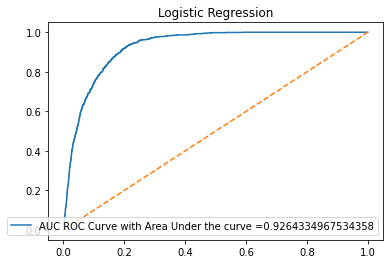

In [68]:
PATH = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/bank-additional-full.csv'
PATH_MODEL = '/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/lr-model.sav'
dat = pd.read_csv(PATH , sep = ';')
# remove duplicated rows or columns 
dat = remove_duplicated(dat)
# fillna by mode 
dat = fillna_by_mode(dat)
#generate columns
dat = generate_cols(dat)
#drop high corr columns 
dat = remove_feature_high_corr(dat)
#encode
dat = encode(dat)
# select features 
dat = select_features(dat)
#model
X_train, X_val,  y_train, y_val = trainTestSplit(dat)
X_train_, y_train_ = SMOTEtrain(X_train, y_train)
model = pickle.load(open(PATH_MODEL, 'rb'))
LR_load(model, X_train_, y_train_, X_val,  y_val)

X_train.shape: (32940, 8), X_val.shape : (8236, 8)
X_train_.shape: (52682, 8)
Accuracy in training set  :  0.8308971996641752
Accuracy in validation set:  0.841271948150573
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7269
           1       0.45      0.81      0.58       967

    accuracy                           0.86      8236
   macro avg       0.71      0.84      0.75      8236
weighted avg       0.91      0.86      0.88      8236



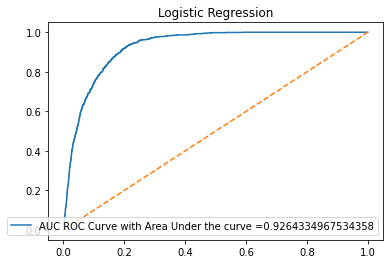

In [61]:
X_train, X_val,  y_train, y_val = trainTestSplit(dat)
X_train_, y_train_ = SMOTEtrain(X_train, y_train)
# model = pickle.load(PATH, mode= 'r')
LR(X_train_, y_train_, X_val,  y_val)


In [48]:
import statsmodels.api as sm
log_reg = sm.Logit(y_train_, X_train_).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.375556
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                52682
Model:                          Logit   Df Residuals:                    52674
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  0.4533
Time:                        17:09:49   Log-Likelihood:                -19785.
converged:                       True   LL-Null:                       -36190.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
age               0.3402      0.083      4.104      0.000       0.178       0.503
duration          1.

In [ ]:
# dat.to_csv('/content/drive/MyDrive/ML/Data_Driven_Marketing/Data-Driven-Marketing-Project2/Data/fillna_by_mode.csv')